<a href="https://colab.research.google.com/github/fbelinchon/ml/blob/master/red_desde_cero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
#from exp.nb_02 import *
import torch.nn.functional as F
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn as nn

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

# Creamos el modelo de datos

## **Creamos el dataset**

In [ ]:
class Dataset():
    def __init__(self, x,y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]
   
    
    

In [ ]:

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

In [ ]:
train_ds,valid_ds=Dataset(x_train,y_train),Dataset(x_valid,y_valid)

tensor(2)


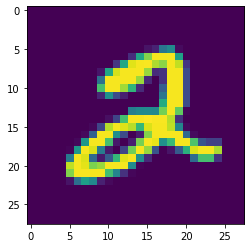

In [ ]:
x,y=train_ds[5]
plt.imshow(x.view(28,28))
print(y)

## Creamos el DataLoader

Creamos un DataLoader para poder extraer información del Dataset en paquetes con tamaño batch size (bs).
Utilizamos yield para devolver un Generator para el batch indicado. <BR>
De esta forma podemos obtener un Iterador para cada batch.<BR>
  __iter__ itera por cada batch y lo que devuelve te permite recorrer los elementos de ese batch en concreto. El for nos devuelve cada uno del los batch al iterar sobre el Dataloader. 

In [ ]:
class DataLoader():
    def __init__(self,ds,bs):
        self.ds,self.bs=ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [ ]:
train_dl=DataLoader(train_ds,10)

In [ ]:
i=0
for x,y in train_dl:  
    i=i+1
    print(y)
    if (i==4): break

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])
tensor([3, 5, 3, 6, 1, 7, 2, 8, 6, 9])
tensor([4, 0, 9, 1, 1, 2, 4, 3, 2, 7])
tensor([3, 8, 6, 9, 0, 5, 6, 0, 7, 6])


## Muestreo aleatorio en los batch


    En cada Epoch hay que obtener batch con diferentes ejemplos. 
    Para ello vamos a utilizar la clase DataLoader de Pytorch que permite indicar si queremos valores aleatorios de batch en cada epoch.

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [ ]:
DataLoader??

In [ ]:
train_dl=DataLoader(train_ds,32,True)

In [ ]:
valid_dl=DataLoader(valid_ds,32,False)

In [ ]:
i=0
for x,y in train_dl:  
    i=i+1
    print(y)
    if (i==4): break

tensor([6, 5, 0, 5, 8, 4, 6, 2, 6, 1, 1, 0, 1, 2, 9, 8, 3, 1, 9, 6, 6, 4, 2, 8,
        3, 1, 4, 8, 2, 6, 2, 6])
tensor([1, 2, 9, 2, 8, 8, 5, 4, 0, 4, 0, 1, 1, 1, 5, 8, 4, 9, 3, 1, 2, 9, 5, 6,
        2, 0, 2, 2, 1, 1, 7, 7])
tensor([6, 9, 0, 8, 0, 8, 4, 8, 1, 1, 0, 2, 4, 5, 4, 5, 8, 5, 1, 4, 1, 7, 9, 0,
        3, 7, 1, 7, 1, 3, 6, 2])
tensor([3, 3, 2, 9, 1, 1, 1, 5, 3, 2, 9, 8, 9, 8, 9, 5, 8, 7, 7, 2, 3, 8, 1, 6,
        8, 9, 3, 6, 3, 3, 4, 3])


# Inicio del modelo.

In [ ]:
train_dl=DataLoader(train_ds,32,True)
valid_dl=DataLoader(valid_ds,32,False)

In [ ]:
modelo = nn.Sequential(
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100,50))

In [ ]:
epo=5
optimi=torch.optim.Adam(modelo.parameters(),lr=1e-3)
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [ ]:
def fit(epoch,model,loss_funcion,optimizer,train_dl,valid_dl):
    for ep in range(epoch):
        tot_loss,tot_acc = 0.,0.
        vtot_loss,vtot_acc = 0.,0.
        for x,y in train_dl:

            out=model(x)
            loss = loss_funcion(out,y)
            with torch.no_grad():
                tot_loss += loss
                tot_acc  += accuracy(out,y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        nv = len(train_dl)
        with torch.no_grad():

            for x,y in valid_dl:

                out=modelo(x)
                vtot_loss += F.cross_entropy(out,y)
                vtot_acc  += accuracy(out,y)

        vnv = len(valid_dl)    
        print('Error '+str(tot_loss/nv)+' Accuracy ' + str(tot_acc/nv)+' Error validación '+ str(vtot_loss/vnv) +' Accuracy validación ' + str(vtot_acc/vnv))
    
        

In [ ]:
fit(10,modelo,F.cross_entropy,optimi,train_dl,valid_dl)

Error tensor(0.3742) Accuracy tensor(0.8979) Error validación tensor(0.1980) Accuracy validación tensor(0.9444)
Error tensor(0.1768) Accuracy tensor(0.9478) Error validación tensor(0.1500) Accuracy validación tensor(0.9587)
Error tensor(0.1246) Accuracy tensor(0.9642) Error validación tensor(0.1137) Accuracy validación tensor(0.9680)
Error tensor(0.0934) Accuracy tensor(0.9725) Error validación tensor(0.1086) Accuracy validación tensor(0.9689)
Error tensor(0.0740) Accuracy tensor(0.9778) Error validación tensor(0.1055) Accuracy validación tensor(0.9693)
Error tensor(0.0589) Accuracy tensor(0.9822) Error validación tensor(0.0938) Accuracy validación tensor(0.9743)
Error tensor(0.0475) Accuracy tensor(0.9857) Error validación tensor(0.1022) Accuracy validación tensor(0.9728)
Error tensor(0.0394) Accuracy tensor(0.9883) Error validación tensor(0.0911) Accuracy validación tensor(0.9746)
Error tensor(0.0318) Accuracy tensor(0.9902) Error validación tensor(0.0919) Accuracy validación tensor(

tensor(4)

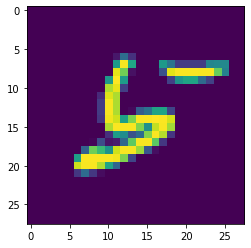

In [ ]:

plt.imshow(valid_dl.dataset.x[91 ].view(28,28))
torch.argmax(modelo(valid_dl.dataset.x[91 ]))



In [ ]:
for i in range(len(valid_dl.dataset.x)):
    out=torch.argmax(modelo(valid_dl.dataset.x[i]))
    y=valid_dl.dataset.y[i]
    if(out != y): print('Indice '+str(i)+' valor y ' + str(y)+' predición '+str(out))

Indice 5 valor y tensor(4) predición tensor(9)
Indice 91 valor y tensor(5) predición tensor(4)
Indice 120 valor y tensor(1) predición tensor(7)
Indice 144 valor y tensor(9) predición tensor(4)
Indice 212 valor y tensor(3) predición tensor(8)
Indice 239 valor y tensor(9) predición tensor(0)
Indice 246 valor y tensor(8) predición tensor(3)
Indice 322 valor y tensor(5) predición tensor(3)
Indice 329 valor y tensor(9) predición tensor(7)
Indice 346 valor y tensor(8) predición tensor(1)
Indice 415 valor y tensor(6) predición tensor(1)
Indice 417 valor y tensor(3) predición tensor(5)
Indice 426 valor y tensor(7) predición tensor(1)
Indice 428 valor y tensor(6) predición tensor(0)
Indice 431 valor y tensor(3) predición tensor(2)
Indice 446 valor y tensor(2) predición tensor(8)
Indice 473 valor y tensor(9) predición tensor(7)
Indice 500 valor y tensor(3) predición tensor(8)
Indice 514 valor y tensor(8) predición tensor(3)
Indice 522 valor y tensor(9) predición tensor(8)
Indice 714 valor y tens

In [ ]:
modelo


Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
)

#Mejora de diseño de clases

Definimos una función para devolver un DataLoader para train y valid.<br>
para train generamos índices aleatorios mientras que para el conjunto de validación no tiene sentido.<br>
También pasamos **kwargs para poder pasar todos los parámetros adicionales a la clase DataLoader.

In [ ]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [ ]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,32
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [ ]:
data=DataBunch(train_dl,valid_dl,c)

Creamos una función para devolver el modelo y el optimizador.<br>
Además la clase Learner que simplemente agrupa todos los objetos necesarios para ejecutar la función fit

In [ ]:
import torch.optim as optim

def get_model(data, lr=0.5, nh=100):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.Adam(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [ ]:
get_model(data)

(Sequential(
   (0): Linear(in_features=784, out_features=100, bias=True)
   (1): ReLU()
   (2): Linear(in_features=100, out_features=10, bias=True)
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.5
     weight_decay: 0
 ))

In [ ]:
learner=Learner(*get_model(data,lr=1e-3),loss_func,data)

In [ ]:
def fit(epoch,learner):
    for ep in range(epoch):
        tot_loss,tot_acc = 0.,0.
        vtot_loss,vtot_acc = 0.,0.
        for x,y in learner.data.train_dl:

            out=learner.model(x)
            loss = learner.loss_func(out,y)
            with torch.no_grad():
                tot_loss += loss
                tot_acc  += accuracy(out,y)

            loss.backward()
            learner.opt.step()
            learner.opt.zero_grad()
        nv = len(learner.data.train_dl)
        with torch.no_grad():

            for x,y in learner.data.valid_dl:

                out=learner.model(x)
                vtot_loss += learner.loss_func(out,y)
                vtot_acc  += accuracy(out,y)

        vnv = len(learner.data.valid_dl)    
        print('Epoch '+str(ep)+' Error '+str(tot_loss/nv)+' Accuracy ' + str(tot_acc/nv)+' Error validación '+ str(vtot_loss/vnv) +' Accuracy validación ' + str(vtot_acc/vnv))
    

In [ ]:
fit(16,learner)

Epoch 0 Error tensor(0.3387) Accuracy tensor(0.9063) Error validación tensor(0.1904) Accuracy validación tensor(0.9475)
Epoch 1 Error tensor(0.1639) Accuracy tensor(0.9514) Error validación tensor(0.1362) Accuracy validación tensor(0.9596)
Epoch 2 Error tensor(0.1138) Accuracy tensor(0.9671) Error validación tensor(0.1082) Accuracy validación tensor(0.9685)
Epoch 3 Error tensor(0.0857) Accuracy tensor(0.9748) Error validación tensor(0.0940) Accuracy validación tensor(0.9719)
Epoch 4 Error tensor(0.0674) Accuracy tensor(0.9797) Error validación tensor(0.0915) Accuracy validación tensor(0.9728)
Epoch 5 Error tensor(0.0544) Accuracy tensor(0.9832) Error validación tensor(0.0950) Accuracy validación tensor(0.9726)
Epoch 6 Error tensor(0.0437) Accuracy tensor(0.9866) Error validación tensor(0.0896) Accuracy validación tensor(0.9745)
Epoch 7 Error tensor(0.0368) Accuracy tensor(0.9891) Error validación tensor(0.0883) Accuracy validación tensor(0.9758)
Epoch 8 Error tensor(0.0297) Accuracy te

# Callbacks

In [ ]:
Learner??


In [ ]:
import pdb;
def one_batch(xb,yb,cb):
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb),yb)
    if not cb.after_loss(loss): return
    
    loss.backward()        
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()
    
    
def all_batches(dl,cb):
    for xb,yb in dl:    
        one_batch(xb,yb,cb)
        if cb.do_stop(): break
    return
        
    

In [ ]:
learner=Learner(*get_model(data,lr=1e-3),loss_func,data)

In [ ]:
def fit(epochs,learn,cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        
        if not cb.begin_epoch(epoch): continue
        all_batches(cb.learn.data.train_dl,cb)
        
        #learn.model.eval()
        if cb.begin_validate():
             with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [ ]:
import statistics as st

class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):        
        self.epoch=epoch
        self.learn.model.train()
        return True
    def begin_validate(self):
        self.learn.model.eval()
        return True
    def after_epoch(self): 
        return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        #return self.learn.model.training
        return True
    def after_backward(self): return True
    def after_step(self): return True
    def do_stop(self): return False

In [ ]:
import statistics as st

class MyCallback(Callback):
    
    def begin_epoch(self, epoch):
        super().begin_epoch(epoch)
        self.t_error=[]
        self.v_error=[]
        self.t_acc=[]
        self.v_acc=[]
        return True

    def after_epoch(self):
        
        print(f'Training: LOSS {st.mean(self.t_error):.4f} Accuracy: {st.mean(self.t_acc)*100:.2f} Validation LOSS {st.mean(self.v_error):.4f} Accuracy: {st.mean(self.v_acc)*100:.2f}')
        return True
    def after_loss(self, loss):
        self.loss = loss
        self.t_error.append(self.loss.item())
        if(self.learn.model.training):
            self.t_error.append(self.loss.item())
            self.t_acc.append(accuracy(self.learn.model(self.xb),self.yb).item())
        else:
            self.v_error.append(self.loss.item())
            self.v_acc.append(accuracy(self.learn.model(self.xb),self.yb).item())
        return self.learn.model.training
    def after_backward(self): return True
    def after_step(self): return True
    def do_stop(self): return False

In [ ]:
callback=MyCallback()

In [ ]:

fit(8,learner,callback)

Training: LOSS 0.2417 Accuracy: 92.87 Validation LOSS 0.1715 Accuracy: 95.33
Training: LOSS 0.1444 Accuracy: 95.70 Validation LOSS 0.1245 Accuracy: 96.53
Training: LOSS 0.1041 Accuracy: 96.89 Validation LOSS 0.1064 Accuracy: 96.82
Training: LOSS 0.0814 Accuracy: 97.60 Validation LOSS 0.0980 Accuracy: 97.23
Training: LOSS 0.0656 Accuracy: 98.10 Validation LOSS 0.0881 Accuracy: 97.42
Training: LOSS 0.0545 Accuracy: 98.41 Validation LOSS 0.0856 Accuracy: 97.49
Training: LOSS 0.0448 Accuracy: 98.77 Validation LOSS 0.0852 Accuracy: 97.59
Training: LOSS 0.0385 Accuracy: 98.93 Validation LOSS 0.0854 Accuracy: 97.61


In [ ]:
modelo.eval??

In [ ]:
class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn=learn
        self.in_train = True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        print('Begin Validate')
        self.learn.model.eval()
        self.in_train=False
        
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

In [ ]:
import statistics

class TestCallback(Callback):
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.n_iters = 0
        
        return True
    def begin_epoch(self,epoch):
        super().begin_epoch(epoch)
        print('BEGIN Epoch ')
        self.t_error = []
        self.t_acc = []
        self.v_error = []
        self.v_acc = []
        
        return True
       
    
    def after_epoch(self):
        self.n_iters = self.n_iters +1
        print('Epoch '+str(self.n_iters))
        #pdb.set_trace()
        #print(f'Validation LOSS {st.mean(self.v_error):.4f} Accuracy: {st.mean(self.v_acc)*100:.2f}')
        #print(f'Training: LOSS {st.mean(self.t_error):.4f} Accuracy: {st.mean(self.t_acc)*100:.2f} Validation LOSS {st.mean(self.v_error):.4f} Accuracy: {st.mean(self.v_acc)*100:.2f}')
              
        return True
    
                      
    def after_loss(self,loss):
        #super().after_loss(loss)
        #self.n_iters += 1
        #print(self.n_iters)
        #if self.n_iters>=10: self.learn.stop = True
        if(self.learn.model.training): 
           
            self.t_error.append(loss.item())
            self.t_acc.append(accuracy(self.learn.model(self.xb),self.yb).item())
        else:
            if(self.v_error):
                print('VAL LOSS')
                self.v_error.append(loss.item())
                self.v_acc.append(accuracy(self.learn.model(self.xb),self.yb).item())
        
        return True

In [ ]:
learner.model.eval()
print(learner.model.training)

False


In [ ]:
#%debug
fit(8, learner, cb=CallbackHandler([TestCallback()]))

BEGIN Epoch 
Begin Validate
Epoch 1
BEGIN Epoch 
Begin Validate
Epoch 2
BEGIN Epoch 
Begin Validate
Epoch 3
BEGIN Epoch 
Begin Validate
Epoch 4
BEGIN Epoch 


KeyboardInterrupt: ignored

In [ ]:
modelo.eval()


Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
)

In [ ]:
modelo.train()
print(modelo.training)


True
